# Notes on Computing the Rollout Acquisition Function
## Considerations
- Using expected improvement as a control variate doesn't behave as anticipated. You can inspect the difference between acquisitions evaluated with or without this control variate by setting the named argument in, simulate_trajectory, variance_reduction to false or true, i.e.: `simulate_trajectory(..., variance_reduction=true)`. The logic for implementing the EI control variate is located at `src/rollout.jl`.

In [83]:
using Distributions
using LinearAlgebra
using Plots
using Profile
using ProfileView
using Cthulhu

All the necessary imports for our computations of interest

In [98]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

to (generic function with 1 method)

## Basic Setup

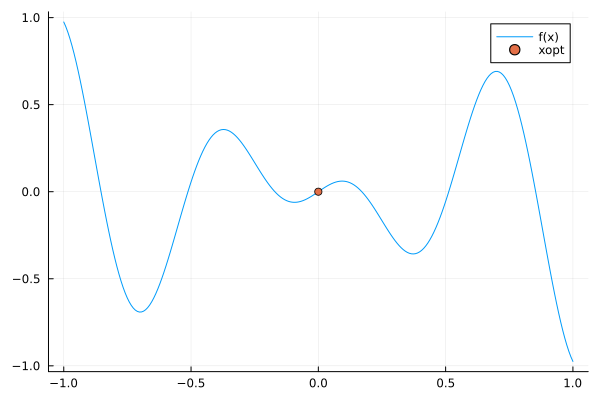

In [99]:
# Visualize 1D test function
testfn = apply_scale(TestLinearCosine1D(1., 9.2), 1.)
# testfn = TestConstant(lbs=[0.], ubs=[1.])
tplot(testfn)

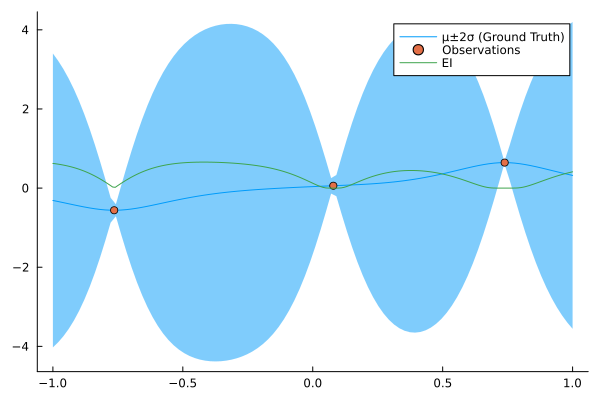

In [137]:
MC_SAMPLES = 500
NUMBER_OF_STARTS = 16
HORIZON = 8
USE_LDS = false
INITIAL_SAMPLES = 3

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
# ψ = kernel_matern52(θ)
ψ = kernel_scale(kernel_matern52, [5., .25])

lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]
domain = first(lbs):.01:first(ubs)

# Generate low discrepancy sequence and standard pseudo-random sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_guesses[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)

# Initialize shared memory for solving base policy in parallel. These values
# are passed to the simulate_trajectory function. We solve the inner policy
# with `NUMBER_OF_STARTS` random starts.
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.15;; .85;;]
yinit = testfn.f.(eachcol(Xinit))

# Fit surrogate with hyperparameters learned via MLE
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
plot1D(sur, xmin=first(lbs), xmax=first(ubs))
EIb = [sur([x]).EI for x in domain]
plot!(domain, EIb, label="EI")

## On Perturbing the jth Policy Solve

Given some policy solve $r_j$, we have the following dependence structure on previous observations:

$$
\newcommand{\bfx}{\mathbf{x}}
\newcommand{\bfr}{\mathbf{r}}
\bfr_j(\bfx_j; \bfx_0, y_0, \ldots, \bfx_{j-1}, y_{j-1}) = 0
$$

In [119]:
h = 1
sfsur = fit_sfsurrogate(sur, h)
fsur = fit_fsurrogate(sur, h-1)

xnew = vec(randsample(1, testfn.dim, lbs, ubs))
update_sfsurrogate!(sfsur, xnew, testfn(xnew))
update_fsurrogate!(fsur, xnew, testfn(xnew))
xnew = vec(randsample(1, testfn.dim, lbs, ubs))
# update_sfsurrogate!(sfsur, xnew, testfn(xnew))
# update_fsurrogate!(fsur, xnew, testfn(xnew))

dp_sur, sp_sur  = fit_perturbation_surrogates(sfsur, h-1)
sfsx = sfsur(xnew, fantasy_index=h-1)
fsx = fsur(xnew)

sp_sx = eval(sp_sur, sfsx, δx=[1.], current_step=h-1)
dp_sx = eval(dp_sur, sfsx, δx=[1.], current_step=h-1);


δX = zeros(testfn.dim, INITIAL_SAMPLES + h)
δX[:, INITIAL_SAMPLES+h] .= 1.
∇ys = [zeros(testfn.dim) for _ in 1:INITIAL_SAMPLES + h]
# ∇ys[end] = testfn.∇f(xnew)
∇ys[end] = fsx.∇μ
δsur = fit_δsurrogate(fsur, δX, ∇ys);
δsx = δsur(fsx);

In [120]:
println("Relative Error δμ: $(norm(δsx.μ - (sp_sx.μ + dp_sx.μ)) / norm(δsx.μ))")
println("Relative Error δ∇μ: $(norm(δsx.∇μ - (sp_sx.∇μ + dp_sx.∇μ)) / norm(δsx.∇μ))")

println("Relative Error δσ: $(norm(δsx.σ - (sp_sx.σ + dp_sx.σ)) / norm(δsx.σ))")
println("Relative Error δ∇σ: $(norm(δsx.∇σ - (sp_sx.∇σ + dp_sx.∇σ)) / norm(δsx.∇σ))")

println("Relative Error δz: $(norm(δsx.z - (sp_sx.z + dp_sx.z)) / norm(δsx.z))")
println("Relative Error δ∇z: $(norm(δsx.∇z - (sp_sx.∇z + dp_sx.∇z)) / norm(δsx.∇z))")

println("Relative Error δEI: $(norm(δsx.EI - (sp_sx.EI + dp_sx.EI)) / norm(δsx.EI))")
println("Relative Error δ∇EI: $(norm(δsx.∇EI - (sp_sx.∇EI + dp_sx.∇EI)) / norm(δsx.∇EI))")

Relative Error δμ: 2.959564608644296e-16
Relative Error δ∇μ: 5.245161664123186e-16
Relative Error δσ: 0.0
Relative Error δ∇σ: 0.0
Relative Error δz: 5.062145449040547e-16
Relative Error δ∇z: 4.8288604814219e-16
Relative Error δEI: 6.072988819162602e-16
Relative Error δ∇EI: 4.107219536956963e-16


In [121]:
resolutions = zeros(1)
tpd = deepcopy(tp)
tpd.mc_iters = 1
deterministic_simulate_trajectory(sur, tpd, initial_guesses, testfn=testfn, resolutions=resolutions)

resolutions = zeros(MC_SAMPLES)
simulate_adjoint_trajectory(sur, tp, initial_guesses, resolutions=resolutions)

(1.2922446251067556, 1.335984544755366)

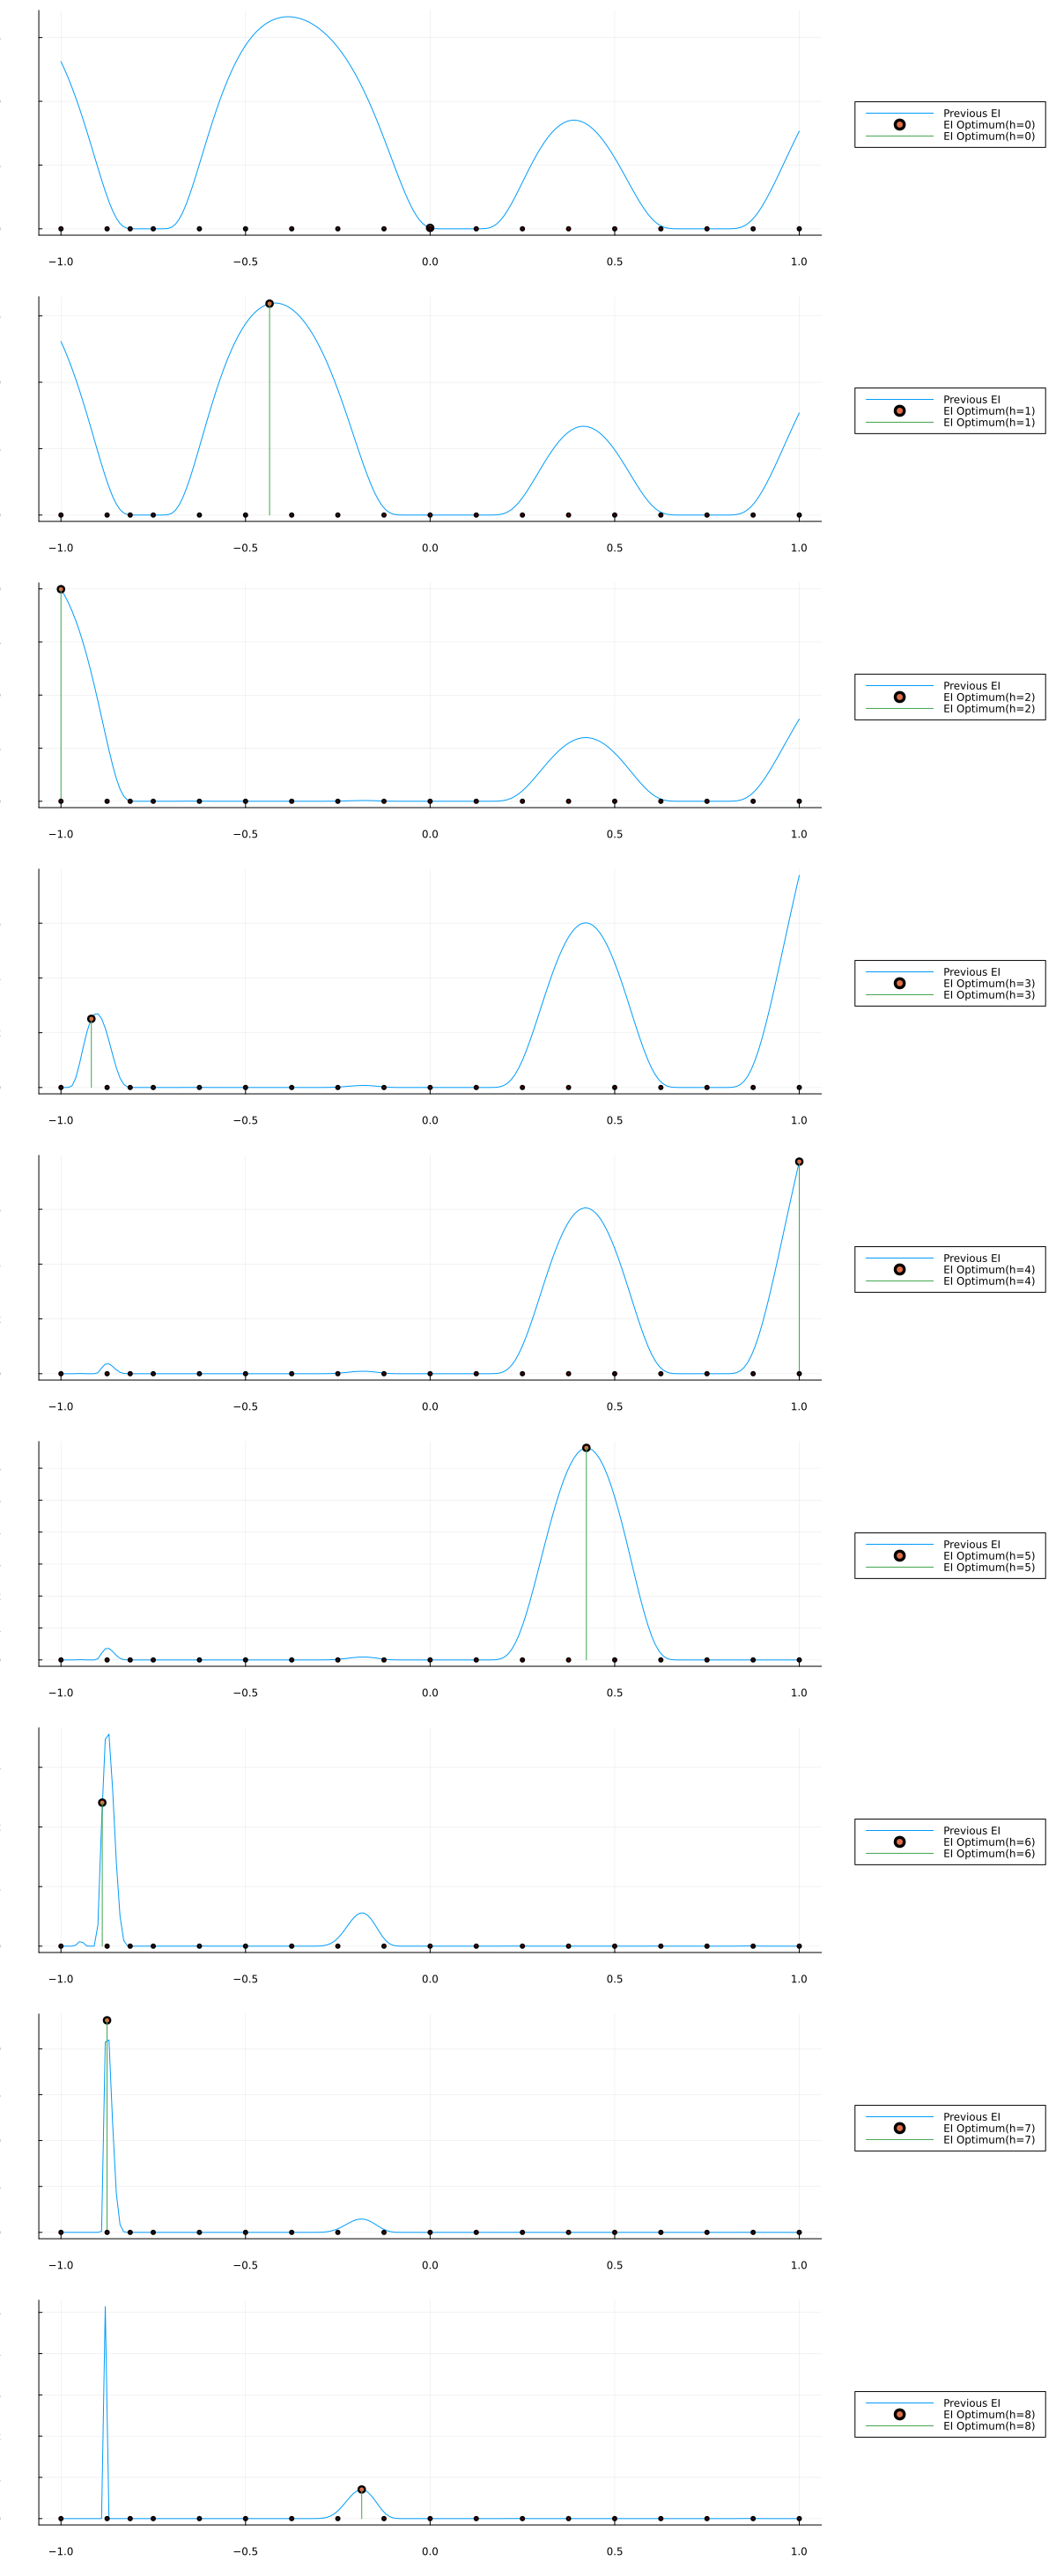

In [138]:
domain = first(lbs):.01:first(ubs)

# Create the trajectory
AT = AdjointTrajectory(sur, tp.x0, tp.h)
T = Trajectory(sur, tp.x0, tp.h)
sampler = gp_sampler_constructor(AT.fs, rns[1, 1, :], HORIZON)

# Adjoint Rollout
adjoint_rollout!(AT, tp.lbs, tp.ubs, xstarts=initial_guesses, get_observation=sampler)
rollout!(T, tp.lbs, tp.ubs, xstarts=initial_guesses, rnstream=rns[1, :, :])

all_plots = []
for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = AT.fs([xx], fantasy_index=upto_index-1).EI
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    scatter!([target_location], [AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    plot!([target_location, target_location], [0., AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    scatter!(p, initial_guesses, zeros(NUMBER_OF_STARTS), color=:red, label=nothing, markersize=2)
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [123]:
function recover_policy_solve(T::AdjointTrajectory; solve_index::Int64)
    @assert solve_index > 0 "The first step isn't chosen via an optimization problem"
    @assert solve_index <= T.h "Can only recover policy solves up to, and including, step $(T.h)"

    N = T.fs.known_observed
    xopt = T.fs.X[:, N + solve_index + 1]
    sx = T.fs(xopt, fantasy_index=solve_index-1)
    
    return sx
end

function solve_dual_y(T::AdjointTrajectory, x_duals::Vector{AbstractVector}; optimal_index::Int64, solve_index::Int64)
    y_dual = 0.
    
    for policy_solve_step in solve_index+1:optimal_index
        dp_sur = fit_data_perturbation_surrogate(T.fs, policy_solve_step - 1)
        sxi = recover_policy_solve(T, solve_index=policy_solve_step)
        y_dual += dot(sxi.∇EI, x_duals[policy_solve_step])
    end
    
    return y_dual
end

function solve_dual_x(T::AdjointTrajectory, y_duals::AbstractVector, x_duals::Vector{AbstractVector}; optimal_index::Int64, solve_index::Int64)
    sx = recover_policy(T, solve_index=solve_index)
    x_dual = -sx.\nabla\mu * y_duals[solve_index]
    
    for policy_solve_step in solve_index+1:optimal_index
        sp_sur = fit_spatial_perturbation_surrogate(T.fs, policy_solve_step - 1)
        sxi = recover_policy(T, solve_index=solve_index)
        x_dual -= sxi.\nablaEI * x_duals[policy_solve_step]
    end

    x_dual = sx.HEI \ x_dual
    
    return x_dual
end

recover_policy_solve (generic function with 1 method)

In [135]:
grad_dense_acquisition = zeros(length(domain))
solve_index = 1
dp_sur, sp_sur = fit_perturbation_surrogates(AT.fs, solve_index-1)
sx = recover_policy_solve(AT, solve_index=solve_index);

println("Number of Base Policy Solves: $HORIZON")
println("Perturbing $(solve_index)th Solve of Base Policy")
for policy_solve_step in 1:solve_index
    sp_sx = eval(sp_sur, sx, δx=[1.], current_step=policy_solve_step-1)
    dp_sx = eval(dp_sur, sx, δx=[1.], current_step=policy_solve_step-1)
    println("$(policy_solve_step - 1)th Spatial Perturbation of EI: $(sp_sx.EI)")
    println("$(policy_solve_step - 1)th Data Perturbation of EI:    $(dp_sx.EI)")
end

ybars = [0., 0.]
xbars = [[0.]]

ybars[end] = 1.
xbars[1] = sx.HEI \ (-sx.∇μ * ybars[end])
dp_sx = eval(dp_sur, sx, δx=[1.], current_step=0)
ybars[1] = dot(dp_sx.EI, xbars[1])
sp_sx = eval(sp_sur, sx, δx=[1.], current_step=0)
atg = AT.fs(AT.fs.X[:, AT.fs.known_observed + 1], fantasy_index=0).∇μ*ybars[1] .+ dot(sp_sx.∇EI, xbars[1])

Number of Base Policy Solves: 1
Perturbing 1th Solve of Base Policy
0th Spatial Perturbation of EI: -0.020210457135766767
0th Data Perturbation of EI:    -0.0032885084078882153


1-element Vector{Float64}:
 -0.03385570525566113

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

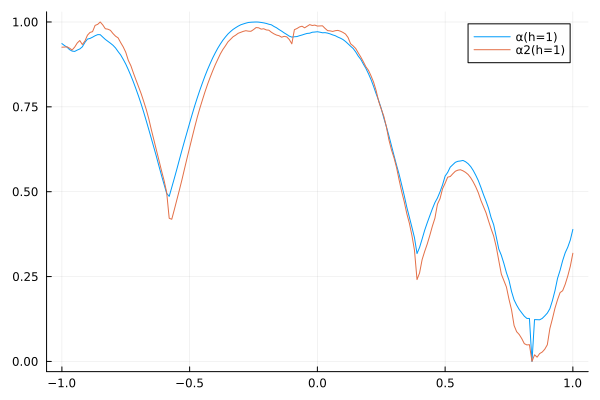

In [136]:
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)
dense_acquisition = zeros(length(domain))
dense_std = zeros(length(domain))
dense_acquisition2 = zeros(length(domain))
grad_dense_acquisition2 = zeros(length(domain))

for (index, xx) in enumerate(domain)
    print("|")
    tp.x0 = [xx]
    dense_acquisition[index], dense_std[index] = simulate_adjoint_trajectory(sur, tp, initial_guesses, resolutions=resolutions)
    dense_acquisition2[index], _, gda = simulate_trajectory(sur, tp, initial_guesses, αxs=resolutions, ∇αxs=gresolutions)
    grad_dense_acquisition2[index] = first(gda)
end
# plot(domain, stdize(dense_acquisition), ribbons=dense_std ./ sqrt(MC_SAMPLES), label="α(h=$HORIZON)")
plot(domain, stdize(dense_acquisition), label="α(h=$HORIZON)")
plot!(domain, stdize(dense_acquisition2), label="α2(h=$HORIZON)")
# plot!(domain, stdize(EIb), label="EI")

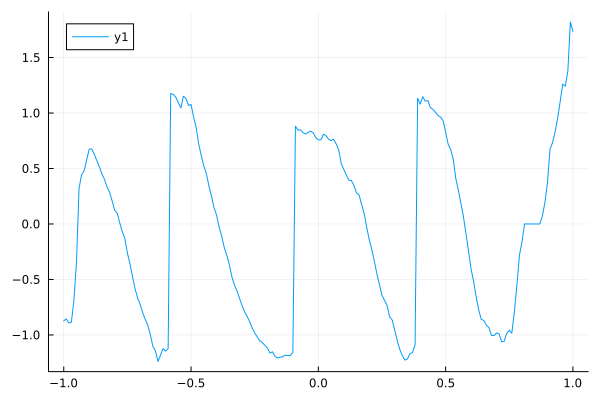

In [126]:
plot(domain, grad_dense_acquisition2)